In [1]:
import os
import numpy as np
import scipy
import matplotlib
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import FuncFormatter,LogLocator
from matplotlib import rcParams
%matplotlib inline

In [2]:
rcParams['font.size'] = 8
colwidth = 246 / 72.27

In [3]:
def symlog_ytick(x, pos):
    if x == 0:
        return f'$\pm 10^{{{syml_th}}}$'
    lx = int(np.log10(abs(x)))
    if x < 0:
        pre = '-'
    else:
        pre = ''
    if lx > syml_th:
        return f'${pre}10^{{{lx}}}$'
    else:
        return None

In [4]:
meas_time = 20.
reps = 30

syml_th = -4

# fit parameters from the ordinary model
dc_fit = 1.7476e-05
tau_fit = 0.06104589

# Data import

In [5]:
dat = np.genfromtxt('COUNT.txt', encoding='utf-8-sig')
dat = np.array(np.split(dat, len(dat)/reps))

delta_raw = (dat[:,:,0]+dat[:,:,1])/dat[:,:,2]-1.

rate_means = np.mean(dat[:,:,2]/meas_time, axis=1)*1e-6
delta_means = np.mean(delta_raw, axis=1)
delta_errs = np.std(delta_raw, axis=1, ddof=1)/np.sqrt(reps)

# Ad hoc fit

In [6]:
# the hypothetical model
def RdetPoly(R, dc, tau, ef, p, R1, e):
    return 1/(1/(dc + ef*R + p*(R/R1)**e) + tau)

# as the model takes the incident rate, we need to sample incident rates
# to create points on the x-y plane of the nonlinearity plot.
# These points are interpolated and the resulting function used for the fit.

# vector of residuals to minimize by least squares
def LS_residuals(pars):
    R = np.logspace(-7,2,100)
    rdet = RdetPoly(R, *pars)
    rdetHalf = RdetPoly(R/2, *pars)
    f = interp1d(rdet, 2*rdetHalf/rdet - 1, bounds_error=False, fill_value=1.)
    return (f(rate_means)-delta_means)/delta_errs

In [7]:
ls = least_squares(LS_residuals, (17e-6, 0.07, 1., 5, 1., 1.01),
                   bounds=([0,       0,  0,   0, 0.1, 0.5],
                           [50e-6, 0.1, 10, 10., 10., 1.5]))

In [8]:
display(ls.x)

array([1.76235701e-05, 6.84580205e-02, 1.09791148e-01, 5.03647334e+00,
       1.20597411e+00, 1.00434902e+00])

# Plotting the ad hoc fit

In [9]:
highlight_boundary = (1e3, 5e5)

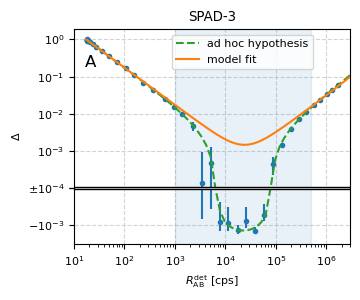

In [10]:
def AdHocPlot():
    
    tit = 'SPAD-3'
    
    bigfontsize = 10
    pcolor = 'tab:blue'    # plot points
    mcolor1 = 'tab:green'  # ad hoc model curve
    mcolor2 = 'tab:orange' # model curve

    fig, ax = plt.subplots(figsize=(colwidth, 2.8))
    
    R = np.logspace(-7,2,100)
    
    # polynomial
    Rdet = RdetPoly(R, *ls.x)
    RdetHalf = RdetPoly(R/2, *ls.x)
    d = 2*RdetHalf/Rdet - 1

    # normal
    RdetN = RdetPoly(R, dc_fit, tau_fit, 1, 0, 1, 0)
    RdetHalfN = RdetPoly(R/2, dc_fit, tau_fit, 1, 0, 1, 0)
    dN = 2*RdetHalfN/RdetN - 1
    
    # plot
    ax.set_xscale('log')
    ax.set_yscale('symlog', linthresh=10**syml_th, linscale=0.001)

    ax.yaxis.set_major_formatter(FuncFormatter(symlog_ytick))

    ax.set_xlim(10, 3e6)

    ax.grid(visible=True, which='major', color='lightgray', linestyle='--', zorder=0)
    ax.set_axisbelow(True)

    plt.errorbar(rate_means*1e6, delta_means, yerr=delta_errs,
                 fmt='o', markersize=3., color=pcolor, zorder=1)
    plt.plot(Rdet*1e6, d, c=mcolor1, ls='--', label='ad hoc hypothesis')
    plt.plot(RdetN*1e6, dN, c=mcolor2, label='model fit')
    
    ax.set_xlabel(r'$R^{\mathrm{det}}_{\mathrm{AB}}$ [cps]')
    ax.set_ylabel(r'$\Delta$')
    
    ax.set_title(tit)
    
    ax.annotate('A', xy=(0.04, 0.88), xycoords='axes fraction', ha='left', va='top',
                 fontsize=12)
    
    ax.axvspan(*highlight_boundary, color='tab:blue', alpha=0.1)

    xb = ax.get_xlim()
    yb = ax.get_ylim()

    axes_break = patches.Rectangle((xb[0], -1.08e-4), xb[1]-xb[0],
                           2.16e-4, fc='w', ec='k', zorder = 3)
    ax.add_patch(axes_break)

    plt.legend(loc='upper center', bbox_to_anchor=(0.61,1))
    plt.tight_layout(pad=0)
    plt.show()
    
    return fig

adHocFig = AdHocPlot()

# Minimal dark counts per point

In [11]:
def Rdet(R, dc, tau):
    return 1/(1/(R+dc)+tau)
def Rinv(Rdet, dc, tau):
    return 1/(1/Rdet-tau)-dc
def DCinv(R, Rdet, tau):
    return 1/(1/Rdet-tau)-R

In [12]:
region_sel = (rate_means*1e6 > highlight_boundary[0]) & (rate_means*1e6 < highlight_boundary[1])

In [13]:
RdetSel = dat[region_sel]/meas_time*1e-6

Here we estimate the minimal dark counts in the following way. Dark counts are initially assumed to be at their lowest. Starting from the lowest detection rates in the data, each data point is evaluated:
1. we see what dark count rate is expected for $R_\text{A}, R_\text{B}$
2. knowing that, we calculate the necessary dark count rate for $R_\text{AB}$ to obtain the corresponding $\Delta$
3. we insert this value to the dark count step function

In [14]:
# the dark count step function
dc_th = [(0, dc_fit)]
dc_needed_means = np.empty(len(RdetSel))
dc_needed_errs = np.empty(len(RdetSel))

for i, Rdet in enumerate(RdetSel):
    RdetHalfMean = np.mean(Rdet[:,0:2])
    for d in dc_th[::-1]:
        if (RdetHalfMean > d[0]):
            dc = d[1]
            break
    Rhalf = Rinv(Rdet[:,:2], dc, tau_fit)
    dc_needed = DCinv(Rhalf[:,0]+Rhalf[:,1], Rdet[:,2], tau_fit)
    dc_needed_means[i] = np.mean(dc_needed)
    dc_needed_errs[i] = np.std(dc_needed, ddof=1)/np.sqrt(reps)
    
    dc_th += [(Rdet[:,2].mean(), dc_needed_means[i])]

# Plotting the parameters

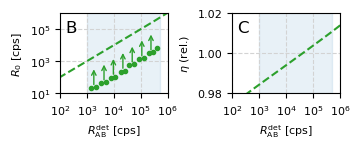

In [15]:
def PlotAdHocPars():
    dc, tau, ef, p, R1, e = ls.x
    
    # blame it on the dark counts
    f_dc = lambda R: (dc + p*(R/R1)**e)*1e6
    # blame it on the efficiency
    f_eff = lambda R: (ef + p*(R/R1)**(e-1))*1e6
    
    fig, ax = plt.subplots(figsize=(colwidth,1.3), ncols=2, nrows=1)
    
    R = np.logspace(-7,2,100)
    Rdet = RdetPoly(R, *ls.x)*1e6
    
    dcx, dcy = (rate_means[region_sel]*1e6, dc_needed_means*1e6)
    
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].plot(Rdet, f_dc(R), ls='--', c='tab:green')
    ax[0].errorbar(dcx, dcy, yerr=dc_needed_errs*1e6, fmt='o', markersize=3., c='tab:green')
    ax[0].set_ylim(1e1, 1e6)
    ax[0].set_ylabel(r'$R_0$ [cps]')
    ax[0].yaxis.set_major_locator(LogLocator(numticks=5))
    ax[0].annotate('B', xy=(0.05, 0.91), xycoords='axes fraction', ha='left', va='top',
                fontsize=12)
    
    coords = np.array([dcx, dcy]).T
    
    for c1, c2 in zip(coords[::2], coords[1::2]):
        ca = (c1+c2)/2
        ax[0].annotate('', xy=(ca[0], ca[1]*20), xytext=ca, arrowprops=dict(ec='tab:green', arrowstyle='->'))
    
    ax[1].set_xscale('log')
    ax[1].plot(Rdet, f_eff(R)/f_eff(1e-2), ls='--', c='tab:green')
    ax[1].set_ylim(0.98, 1.02)
    ax[1].set_ylabel(r'$\eta$ (rel.)')
    ax[1].annotate('C', xy=(0.05, 0.91), xycoords='axes fraction', ha='left', va='top',
                fontsize=12)    
    for a in ax:
        a.grid(visible=True, color='lightgray', linestyle='--', zorder=0)
        a.set_xlabel(r'$R^{\mathrm{det}}_{\mathrm{AB}}$ [cps]')
        a.set_xlim(1e2, 1e6)
        a.xaxis.set_major_locator(LogLocator(numticks=5))
        a.axvspan(*highlight_boundary, color='tab:blue', alpha=0.1)

    plt.tight_layout(pad=0)
    plt.show()
    
    return fig

adHocParsFig = PlotAdHocPars()    